Jianming Yang 20383255

This code uses SimpleITK to read , transform and rewrite the brain tumor data. The important information about the data like size, spacing, origin, direction, pixel type are presented after reading. Array information extracted by SimpleITK are used to plot images and data distributions using matplotlib. 3D slicer images were inserted to povide tumor center information to help transformation. Then the transformation shifted the origin of the data to the interscetion of 3 specific slices where the tumor center is at, and this data is used to write the new brain tumor file. Additoional snapshots are attached to support the completion of such tranlational transformation.

In [14]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
%matplotlib inline
img = sitk.ReadImage("BrainTumor_MRI.nii")

In [15]:
img = cv2.imread("BrainTumor_MRI.nii")

In [16]:
img

In [10]:
# define the function to extract important information from the image object
def image_info(img):
    print('size: ',img.GetSize())
    print('spacing: ',img.GetSpacing())
    print('origin: ',img.GetOrigin())
    print('direction: ',img.GetDirection())
    print('pixel type: ',img.GetPixelIDTypeAsString())

In [11]:
image_info(img)

size:  (256, 256, 112)
spacing:  (0.9375, 0.9375, 1.399999976158142)
origin:  (-119.53099822998047, -119.53099822998047, -77.69999694824219)
direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
pixel type:  16-bit signed integer


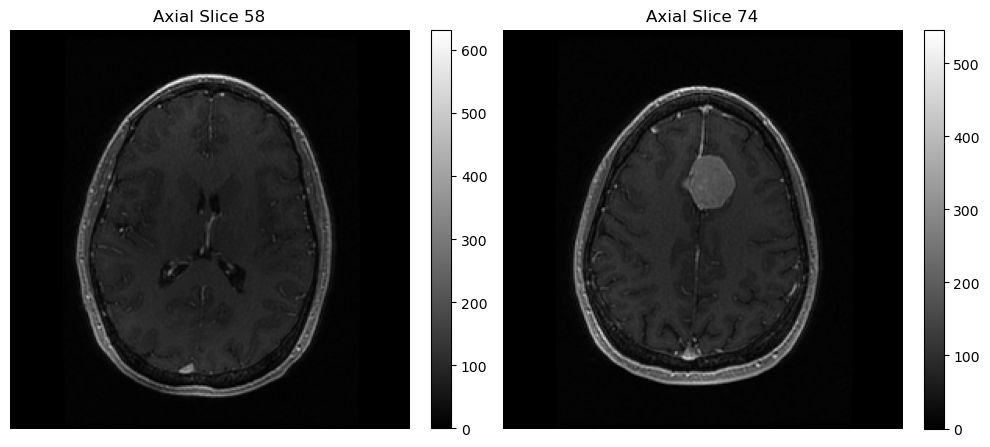

In [17]:
# Get the pixel values of the MRI volume as a Numpy array
img_array = sitk.GetArrayFromImage(img)

# Plotting 2 image data side by side, with colorbar and without axis
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# first image is axial slice with index 58, with tumor
img1 = axes[0].imshow(img_array[58,:,:], cmap='gray')
axes[0].set_title('Axial Slice 58')
cbar1 = fig.colorbar(img1, ax=axes[0],fraction=0.0452)
axes[0].axis('off')

# Second image is axial slice with index 74, without tumor
img2 = axes[1].imshow(img_array[74,:,:], cmap='gray')
axes[1].set_title('Axial Slice 74')
cbar1 = fig.colorbar(img2, ax=axes[1],fraction=0.0452)
axes[1].axis('off')

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

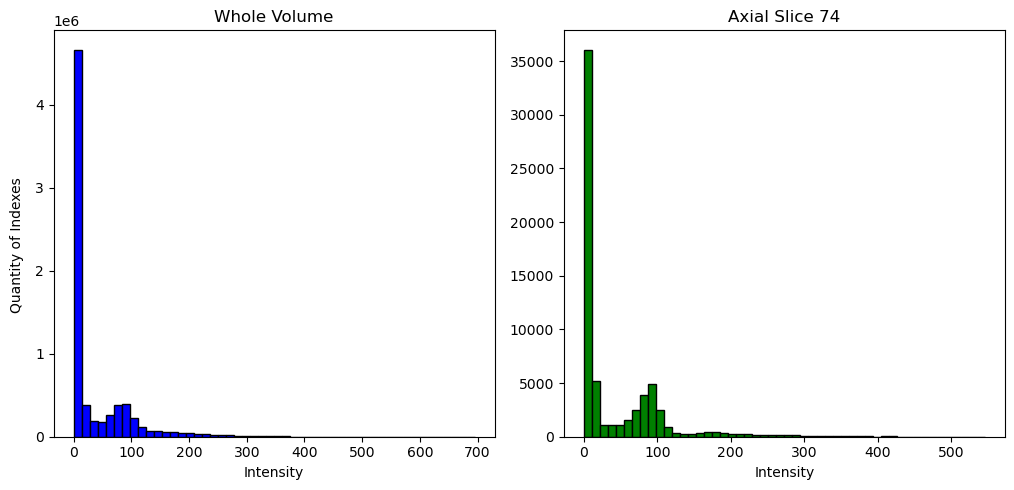

In [13]:
# Flatten the voxel data for the whole volume
flattened_volume = img_array.flatten()

# Flatten the voxel data for the axial slice with index 74
axial_slice = img_array[74, :, :]
flattened_axial_slice = axial_slice.flatten()

# Plotting 2 image data side by side, differentiated by the 2 axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the histogram for the whole volume, specified bar width, color, outline
# y axis is the amount of pixels(frequency), x axis is the intensity(pixel value)
axes[0].hist(flattened_volume, bins=50, color='blue',edgecolor="black")
axes[0].set_title('Whole Volume')
axes[0].set_xlabel('Intensity')


# Plot the histogram for the axial slice with index 74, specified bar width, color, outline
# y axis is the amount of indexes(frequency), x axis is the intensity(pixel value)
axes[1].hist(flattened_axial_slice, bins=50, color='green',edgecolor="black")
axes[1].set_title('Axial Slice 74')
axes[1].set_xlabel('Intensity')


# Set common y-axis label, specified location, name, position and orientation
fig.text(-0.01, 0.5, 'Quantity of Indexes', va='center', rotation='vertical')

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()

The first figure showed that the intesity close to 0 having a extremely high peek hindering the observation ofthe data distribution of higher intesities. Knowing that most of the low values were due to the large dark background,it is better to also show the portion below a certain value. So the new figure is created to highlight the other peekat round 100 and the distribution condition for other levels of intensities.


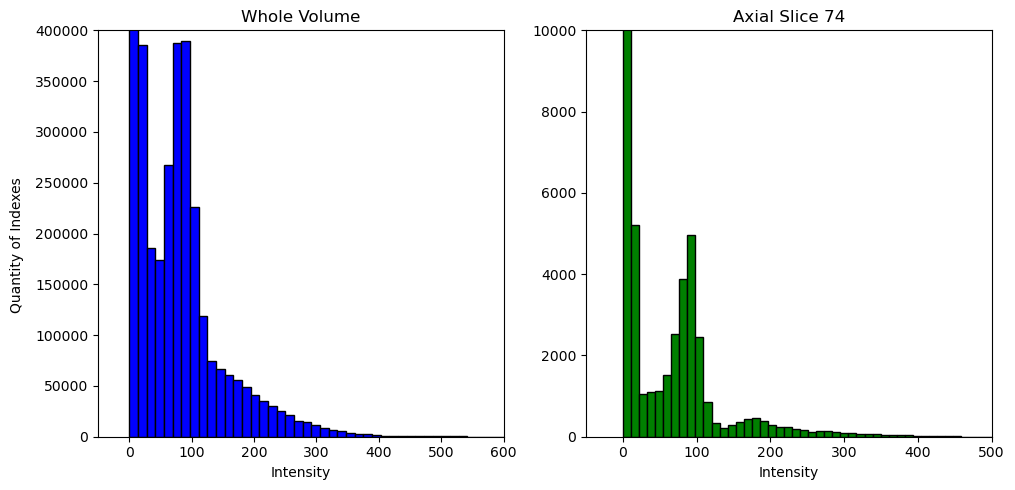

In [18]:
print("The first figure showed that the intesity close to 0 having a extremely high peek hindering the observation of" 
      "the data distribution of higher intesities. Knowing that most of the low values were due to the large dark background,"
      "it is better to also show the portion below a certain value. So the new figure is created to highlight the other peek"
      "at round 100 and the distribution condition for other levels of intensities.")
# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the histogram for the whole volume
axes[0].hist(flattened_volume, bins=50, color='blue',edgecolor="black")
axes[0].set_title('Whole Volume')
axes[0].set_xlabel('Intensity')

# show only defined region of the whole grpah
axes[0].set_ylim([0, 0.4e6])
axes[0].set_xlim([-50, 600])

# Plot the histogram for the axial slice
axes[1].hist(flattened_axial_slice, bins=50, color='green',edgecolor="black")
axes[1].set_title('Axial Slice 74')
axes[1].set_xlabel('Intensity')

# show only defined region of the whole grpah
axes[1].set_ylim([0, 10000])
axes[1].set_xlim([-50, 500])

# Give common y axis title
fig.text(-0.01, 0.5, 'Quantity of Indexes', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

<img src="Coordinates.png" alt="Image Title" width="800" height="600">

This is a snapshot from 3D slicer giving the tumor center's position information using RAS coordinate system. Since the Coordinate values are taken from a RAS system, having negative value for R means that this location is opposite to the right, meaning that the point is on the left of the origin. So in a LPS system, the values will be L: 3.2494866900900092, P: -29.16931690956382, S: 28.700001239776615.

This is a snapshot from 3D slicer showing the located tumor center (point F) from all 3 angle of  slices.
<img src="Focused_F.png" alt="Image Title" width="1600" height="1200">

This is a snapshot from 3D slicer showing the vertical extent of the tumor to be 31.00 mm, measured by line L.
<img src="Length.png" alt="Image Title" width="1600" height="1200">

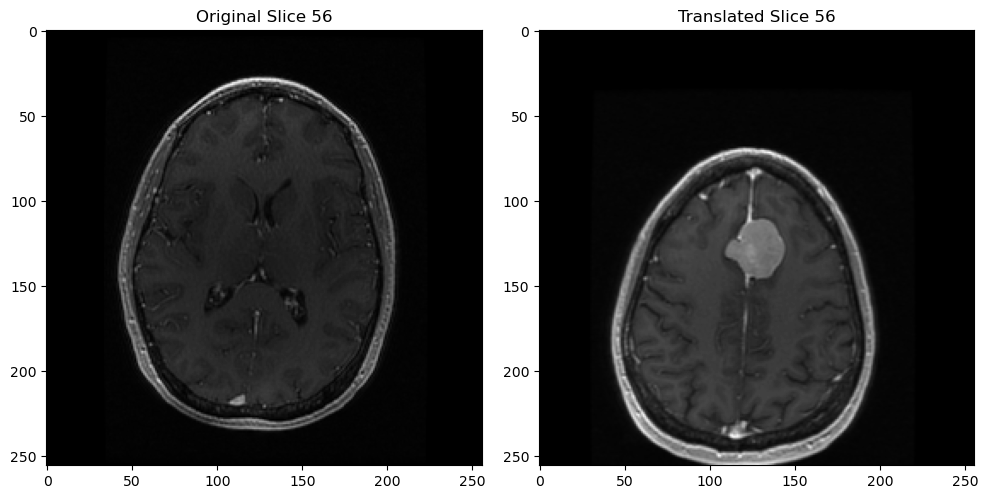

In [19]:
# Since R correspond to -i, A correspond to -j and S correspond to k, 
# LPS values are used to define the tumor center location
tumor_center = (3.249,-29.16931690956382,28.700001239776615)

# Calculate the translation vector (how much in each direction need to be shifted)
translation_vector = [tumor_center[0], tumor_center[1], tumor_center[2]]

# Use TranslationTransform function to perform transliation, '3' specifies in 3D space
translation_transform = sitk.TranslationTransform(3, translation_vector)

# Resample returns a new resampled image that has been transformed onto the original grid
translated_volume = sitk.Resample(img, translation_transform)

# Plot the original volume and the translated volume side by side for axial slice with index 56
axial_slice_index = 56
original_axial_slice = sitk.GetArrayViewFromImage(img)[axial_slice_index, :, :]
translated_axial_slice = sitk.GetArrayViewFromImage(translated_volume)[axial_slice_index, :, :]

# Create a figure and axes using subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original axial slice
axes[0].imshow(original_axial_slice, cmap="gray")
axes[0].set_title("Original Slice 56")

# Plot the translated axial slice
axes[1].imshow(translated_axial_slice, cmap="gray")
axes[1].set_title("Translated Slice 56")


plt.tight_layout()
plt.show()

# Source: https://simpleitk.org/

In [20]:
# Use SimpleITK to write the transformed file
sitk.WriteImage(translated_volume,"T_BrainTumor_MRI.nii")

# Source: https://simpleitk.org/

The transformed file is presented in 3D slicer, and by inputing the markup point to have RAS postion (0,0,0), we can confirm that the transformed file has the tumor center as its origin.
<img src="Validation.png" alt="Image Title" width="1600" height="1200">